# Part 1: Data Loading and Preprocessing - Phase 1 Dataset

**Goal:** Load and inspect the BIOQIC FEM Box simulation (`four_target_phantom.mat`)

**Dataset:** Phase 1 - Simple box geometry with 4 target inclusions of different stiffness

## Objectives:
1. Load `.mat` file and understand its structure
2. Extract displacement fields (u_x, u_y, u_z)
3. Extract ground truth stiffness (complex shear modulus)
4. Visualize displacement fields and stiffness distribution
5. Build preprocessing utilities (normalization, coordinate grids)
6. Generate collocation points for physics loss

In [1]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from pathlib import Path

# Set plotting style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)

print("Libraries imported successfully!")

Matplotlib is building the font cache; this may take a moment.


Libraries imported successfully!


## 1. Load BIOQIC Box Dataset

In [8]:
# Define data path
# Box phantom has two versions:
# 1. four_target_phantom.mat - Single frequency displacement (5D: y, x, z, direction, frequency)
# 2. four_target_phantom_timesteps.mat - Time-resolved simulation data
data_path = Path('data/raw/bioqic/four_target_phantom.mat')

# Check if file exists
if not data_path.exists():
    raise FileNotFoundError(f"Dataset not found at {data_path}")

# Load .mat file
print(f"Loading dataset from: {data_path}")
data = sio.loadmat(data_path)

print("\n=== Dataset Keys ===")
for key in data.keys():
    if not key.startswith('__'):  # Skip metadata keys
        if hasattr(data[key], 'shape'):
            print(f"  {key}: {type(data[key])} - Shape: {data[key].shape}, Dtype: {data[key].dtype}")
        else:
            print(f"  {key}: {type(data[key])}")


Loading dataset from: data\raw\bioqic\four_target_phantom.mat

=== Dataset Keys ===
  u_ft: <class 'numpy.ndarray'> - Shape: (100, 80, 10, 3, 6), Dtype: complex128

=== Dataset Keys ===
  u_ft: <class 'numpy.ndarray'> - Shape: (100, 80, 10, 3, 6), Dtype: complex128


## 2. Inspect Data Structure

In [9]:
# Explore the main data structures
# BIOQIC datasets typically contain:
# - u: displacement field (complex)
# - Nodes: spatial coordinates
# - stiffness/modulus: ground truth

# List all non-metadata keys
data_keys = [k for k in data.keys() if not k.startswith('__')]

print("\n=== Detailed Inspection ===")
for key in data_keys:
    item = data[key]
    print(f"\n{key}:")
    print(f"  Type: {type(item)}")
    if hasattr(item, 'shape'):
        print(f"  Shape: {item.shape}")
        print(f"  Dtype: {item.dtype}")
        if np.prod(item.shape) < 100:  # Only print if small
            print(f"  Values: {item}")
        else:
            print(f"  Min: {item.min():.6f}, Max: {item.max():.6f}, Mean: {item.mean():.6f}")


=== Detailed Inspection ===

u_ft:
  Type: <class 'numpy.ndarray'>
  Shape: (100, 80, 10, 3, 6)
  Dtype: complex128
  Min: -0.028130+0.006911j, Max: 0.024865-0.009202j, Mean: 0.000115-0.000132j


## 3. Extract and Process 5D Displacement Array

Based on BIOQIC documentation:
- **Data format**: 5D complex MATLAB array
- **Dimensions**: (y, x, z, direction, frequency)
  - y: 100 (rows)
  - x: 80 (cols) 
  - z: 10 (slices)
  - direction: 3 (1=y, 2=x, 3=z motion encoding)
  - frequency: 4 ([50, 60, 70, 80] Hz)
- **Voxel spacing**: 1 mm isotropic
- **Key name**: 'u_ft' (Fourier transform of displacement)


In [10]:
# Extract displacement field - BIOQIC Box uses 'u_ft' key (5D array)
if 'u_ft' in data:
    displacement_5d = data['u_ft']
    print(f"Found displacement field: 'u_ft'")
    print(f"  Shape: {displacement_5d.shape}")
    print(f"  Expected format: (y, x, z, direction, frequency)")
    print(f"  Dtype: {displacement_5d.dtype}")
    print(f"  Is complex: {np.iscomplexobj(displacement_5d)}")
    
    # According to documentation: (100, 80, 10, 3, 4)
    # Frequencies: [50, 60, 70, 80] Hz
    # For Phase 1, let's use 60 Hz (index 1)
    freq_idx = 1  # 60 Hz
    frequencies = [50, 60, 70, 80]
    selected_freq = frequencies[freq_idx]
    
    print(f"\n📍 Selecting frequency: {selected_freq} Hz (index {freq_idx})")
    
    # Extract displacement at selected frequency: shape (100, 80, 10, 3)
    displacement_4d = displacement_5d[:, :, :, :, freq_idx]
    print(f"  Displacement at {selected_freq} Hz: {displacement_4d.shape}")
    
    # Generate coordinate grid
    # Box dimensions based on 1mm voxel spacing
    ny, nx, nz = displacement_4d.shape[0], displacement_4d.shape[1], displacement_4d.shape[2]
    voxel_size = 0.001  # 1 mm = 0.001 m
    
    # Create meshgrid (in meters)
    y = np.arange(ny) * voxel_size  # 0 to 0.099 m
    x = np.arange(nx) * voxel_size  # 0 to 0.079 m
    z = np.arange(nz) * voxel_size  # 0 to 0.009 m
    
    yy, xx, zz = np.meshgrid(y, x, z, indexing='ij')
    
    # Flatten to (N, 3) array where N = 100*80*10 = 80,000
    coordinates = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
    print(f"\n📐 Generated coordinate grid:")
    print(f"  Shape: {coordinates.shape}")
    print(f"  X range: [{coordinates[:, 0].min():.6f}, {coordinates[:, 0].max():.6f}] m")
    print(f"  Y range: [{coordinates[:, 1].min():.6f}, {coordinates[:, 1].max():.6f}] m")
    print(f"  Z range: [{coordinates[:, 2].min():.6f}, {coordinates[:, 2].max():.6f}] m")
    
    # Reshape displacement to (N, 3) - flatten spatial dimensions
    # Original: (100, 80, 10, 3) -> (80000, 3)
    # Direction order in data: 1=y, 2=x, 3=z
    # Reorder to standard x, y, z
    displacement = np.zeros((ny * nx * nz, 3), dtype=complex)
    displacement[:, 0] = displacement_4d[:, :, :, 1].ravel()  # x component
    displacement[:, 1] = displacement_4d[:, :, :, 0].ravel()  # y component
    displacement[:, 2] = displacement_4d[:, :, :, 2].ravel()  # z component
    
    print(f"\n🌊 Displacement field:")
    print(f"  Shape: {displacement.shape}")
    print(f"  Components: [u_x, u_y, u_z]")
    print(f"  Magnitude range: [{np.abs(displacement).min():.6e}, {np.abs(displacement).max():.6e}] m")
    
else:
    print("⚠️  'u_ft' key not found in dataset!")
    print("Available keys:", [k for k in data.keys() if not k.startswith('__')])


Found displacement field: 'u_ft'
  Shape: (100, 80, 10, 3, 6)
  Expected format: (y, x, z, direction, frequency)
  Dtype: complex128
  Is complex: True

📍 Selecting frequency: 60 Hz (index 1)
  Displacement at 60 Hz: (100, 80, 10, 3)

📐 Generated coordinate grid:
  Shape: (80000, 3)
  X range: [0.000000, 0.079000] m
  Y range: [0.000000, 0.099000] m
  Z range: [0.000000, 0.009000] m

🌊 Displacement field:
  Shape: (80000, 3)
  Components: [u_x, u_y, u_z]
  Magnitude range: [0.000000e+00, 2.812524e-02] m


In [16]:
# Generate ground truth stiffness distribution
# According to BIOQIC description and MRE_EigPIELM implementation:
# - Background: 3 kPa
# - Four targets: 10 kPa (decreasing size)
# - Viscosity: 1 Pa·s (Voigt model)

print("🎯 Creating ground truth stiffness map")
print("   Method: Geometric segmentation + Voigt model")

# Import skimage for geometric shapes
import skimage.draw
import scipy.ndimage

# Step 1: Segment spatial regions (identify the 4 target locations)
print("\n1. Segmenting spatial regions...")

# Create 2D mask for targets in the (y, x) plane
# Based on BIOQIC FEM Box geometry from MRE_EigPIELM repo
# Target centers (y, x coordinates in voxels):
disks = [
    skimage.draw.disk(center=(73.6, 39.8), radius=10),  # Target 1 (largest, r=10mm)
    skimage.draw.disk(center=(49.6, 39.8), radius=5),   # Target 2 (r=5mm)
    skimage.draw.disk(center=(31.8, 39.8), radius=3),   # Target 3 (r=3mm)
    skimage.draw.disk(center=(18.6, 39.8), radius=2),   # Target 4 (smallest, r=2mm)
]

# Create spatial region mask (2D for y-x plane)
spatial_region_2d = np.ones((ny, nx), dtype=int)  # Background = region 1

# Assign each target a region ID
for idx, disk in enumerate(disks, start=2):
    rr, cc = disk
    spatial_region_2d[rr, cc] = idx

print(f"   Identified {len(disks)} target regions")
print(f"   Region IDs: 1 (background), 2-5 (targets)")

# Extend to 3D by replicating across z-slices
spatial_region_3d = np.repeat(spatial_region_2d[:, :, np.newaxis], nz, axis=2)

# Flatten to match coordinate array shape
spatial_region = spatial_region_3d.ravel()

print(f"   Spatial region shape: {spatial_region.shape}")
print(f"   Unique regions: {np.unique(spatial_region)}")

# Step 2: Assign stiffness values to each region
print("\n2. Assigning stiffness values...")

# Ground truth stiffness values (Pa) for each region
# Region 0: Outside (not used), Region 1: Background, Regions 2-5: Targets
mu_values = np.array([
    0,      # Region 0: Not used
    3e3,    # Region 1: Background (3 kPa)
    10e3,   # Region 2: Target 1 (10 kPa)
    10e3,   # Region 3: Target 2 (10 kPa)
    10e3,   # Region 4: Target 3 (10 kPa)
    10e3    # Region 5: Target 4 (10 kPa)
])

# Create stiffness map by indexing with spatial_region
mu_real = mu_values[spatial_region]

print(f"   Background stiffness: {mu_values[1]:.0f} Pa")
print(f"   Target stiffness: {mu_values[2]:.0f} Pa")

# Step 3: Apply Voigt viscoelastic model
print("\n3. Applying Voigt model (μ = μ' + iωη)...")

# Voigt model: μ = μ_real + i * ω * η
eta = 1.0  # Pa·s (shear viscosity)
omega = 2 * np.pi * selected_freq  # Angular frequency

mu_imag = omega * eta  # Loss modulus (imaginary part)

# Create complex stiffness array
stiffness = mu_real + 1j * mu_imag
stiffness = stiffness.reshape(-1, 1)  # Shape: (N, 1)

print(f"   Viscosity (η): {eta} Pa·s")
print(f"   Angular frequency (ω): {omega:.2f} rad/s")
print(f"   Loss modulus (ωη): {mu_imag:.1f} Pa")

# Verify
print(f"\n✅ Ground Truth Stiffness Created:")
print(f"   Shape: {stiffness.shape}")
print(f"   Type: Complex (μ' + iμ\")")
print(f"   Storage modulus (μ'): [{stiffness.real.min():.1f}, {stiffness.real.max():.1f}] Pa")
print(f"   Loss modulus (μ\"): {stiffness.imag.flatten()[0]:.1f} Pa (constant)")
print(f"   Number of voxels in background: {np.sum(spatial_region == 1):,}")
print(f"   Number of voxels in targets: {np.sum(spatial_region >= 2):,}")


🎯 Creating ground truth stiffness map
   Method: Geometric segmentation + Voigt model

1. Segmenting spatial regions...
   Identified 4 target regions
   Region IDs: 1 (background), 2-5 (targets)
   Spatial region shape: (80000,)
   Unique regions: [1 2 3 4 5]

2. Assigning stiffness values...
   Background stiffness: 3000 Pa
   Target stiffness: 10000 Pa

3. Applying Voigt model (μ = μ' + iωη)...
   Viscosity (η): 1.0 Pa·s
   Angular frequency (ω): 376.99 rad/s
   Loss modulus (ωη): 377.0 Pa

✅ Ground Truth Stiffness Created:
   Shape: (80000, 1)
   Type: Complex (μ' + iμ")
   Storage modulus (μ'): [3000.0, 10000.0] Pa
   Loss modulus (μ"): 377.0 Pa (constant)
   Number of voxels in background: 75,630
   Number of voxels in targets: 4,370


## 4. Visualize Stiffness Distribution (if available)

The box phantom has 4 target inclusions with 10 kPa stiffness in a 3 kPa background.


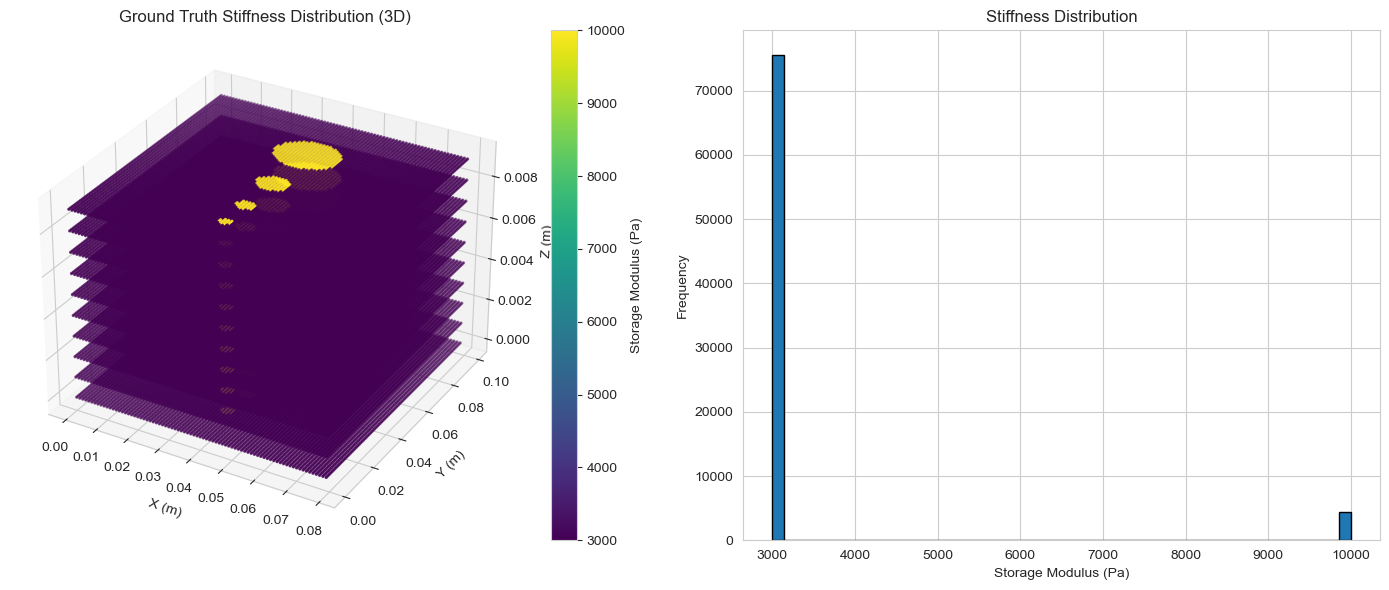


Number of distinct stiffness regions: 2
Stiffness values: [ 3000. 10000.] Pa


In [17]:
if stiffness is not None and coordinates is not None:
    # For complex stiffness, visualize magnitude
    if np.iscomplexobj(stiffness):
        stiffness_mag = np.abs(stiffness)
        stiffness_plot = stiffness.real  # Storage modulus for visualization
        label = 'Storage Modulus (Pa)'
    else:
        stiffness_mag = stiffness
        stiffness_plot = stiffness
        label = 'Stiffness (Pa)'
    
    # Check if stiffness has variation (non-uniform)
    if stiffness_plot.std() > 0.1:
        # 3D scatter plot
        fig = plt.figure(figsize=(14, 6))
        
        # 3D view
        ax1 = fig.add_subplot(121, projection='3d')
        scatter = ax1.scatter(coordinates[:, 0], coordinates[:, 1], coordinates[:, 2],
                             c=stiffness_plot.flatten(), cmap='viridis', s=2)
        ax1.set_xlabel('X (m)')
        ax1.set_ylabel('Y (m)')
        ax1.set_zlabel('Z (m)')
        ax1.set_title('Ground Truth Stiffness Distribution (3D)')
        plt.colorbar(scatter, ax=ax1, label=label)
        
        # Histogram
        ax2 = fig.add_subplot(122)
        ax2.hist(stiffness_plot.flatten(), bins=50, edgecolor='black')
        ax2.set_xlabel(label)
        ax2.set_ylabel('Frequency')
        ax2.set_title('Stiffness Distribution')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
        
        # Print unique stiffness values to identify the 4 targets
        unique_stiff = np.unique(np.round(stiffness_plot.flatten(), 0))
        print(f"\nNumber of distinct stiffness regions: {len(unique_stiff)}")
        print(f"Stiffness values: {unique_stiff} Pa")
    else:
        print(f"Stiffness is uniform: {stiffness_plot.mean():.1f} Pa")
        print("Ground truth target locations not available in this file.")
else:
    print("⚠️  Skipping stiffness visualization (data not available)")


## 5. Visualize Displacement Field

Displacement magnitude statistics:
  Min: 1.824231e-04 m
  Max: 2.813671e-02 m
  Mean: 1.103007e-02 m
  Std: 6.035674e-03 m


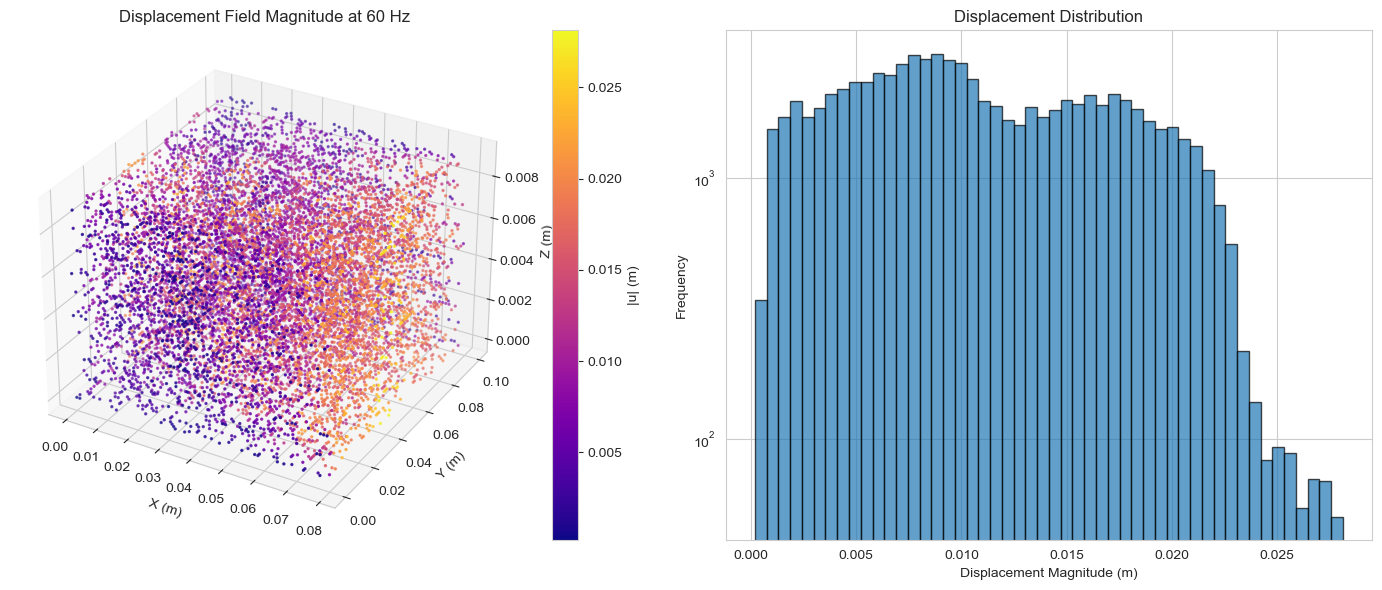

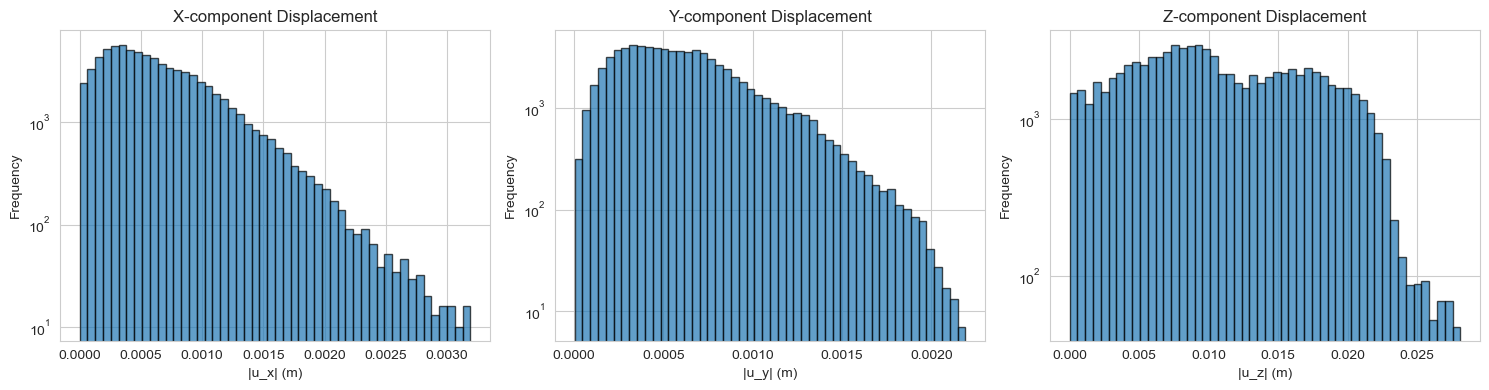

In [18]:
if displacement is not None and coordinates is not None:
    # Calculate magnitude of complex displacement vector
    # |u| = sqrt(|ux|^2 + |uy|^2 + |uz|^2)
    disp_mag = np.sqrt(np.abs(displacement[:, 0])**2 + 
                       np.abs(displacement[:, 1])**2 + 
                       np.abs(displacement[:, 2])**2)
    
    print(f"Displacement magnitude statistics:")
    print(f"  Min: {disp_mag.min():.6e} m")
    print(f"  Max: {disp_mag.max():.6e} m")
    print(f"  Mean: {disp_mag.mean():.6e} m")
    print(f"  Std: {disp_mag.std():.6e} m")
    
    # 3D visualization - subsample for better performance
    n_plot = min(10000, len(disp_mag))  # Plot max 10k points
    indices = np.random.choice(len(disp_mag), size=n_plot, replace=False)
    
    fig = plt.figure(figsize=(14, 6))
    
    ax1 = fig.add_subplot(121, projection='3d')
    scatter = ax1.scatter(coordinates[indices, 0], coordinates[indices, 1], coordinates[indices, 2],
                         c=disp_mag[indices], cmap='plasma', s=2)
    ax1.set_xlabel('X (m)')
    ax1.set_ylabel('Y (m)')
    ax1.set_zlabel('Z (m)')
    ax1.set_title(f'Displacement Field Magnitude at {selected_freq} Hz')
    plt.colorbar(scatter, ax=ax1, label='|u| (m)')
    
    # Histogram
    ax2 = fig.add_subplot(122)
    ax2.hist(disp_mag, bins=50, edgecolor='black', alpha=0.7)
    ax2.set_xlabel('Displacement Magnitude (m)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Displacement Distribution')
    ax2.set_yscale('log')
    ax2.grid(True)
    
    plt.tight_layout()
    plt.show()
    
    # Plot displacement components separately
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    component_names = ['X', 'Y', 'Z']
    
    for i, (ax, name) in enumerate(zip(axes, component_names)):
        disp_comp_mag = np.abs(displacement[:, i])
        ax.hist(disp_comp_mag, bins=50, edgecolor='black', alpha=0.7)
        ax.set_xlabel(f'|u_{name.lower()}| (m)')
        ax.set_ylabel('Frequency')
        ax.set_title(f'{name}-component Displacement')
        ax.set_yscale('log')
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()
else:
    print("⚠️  Displacement or coordinates not available for visualization")


## 6. Data Preprocessing Utilities

In [19]:
class MREDataPreprocessor:
    """Preprocessing utilities for MRE data."""
    
    def __init__(self):
        self.coord_mean = None
        self.coord_std = None
        self.disp_scale = None
        self.stiff_scale = None
    
    def normalize_coordinates(self, coords, fit=True):
        """Normalize coordinates to [-1, 1] range."""
        if fit:
            self.coord_mean = coords.mean(axis=0)
            self.coord_std = coords.std(axis=0)
        
        coords_normalized = (coords - self.coord_mean) / (self.coord_std + 1e-10)
        return coords_normalized
    
    def normalize_displacement(self, disp, fit=True):
        """Normalize displacement field."""
        if fit:
            if np.iscomplexobj(disp):
                self.disp_scale = np.max(np.abs(disp))
            else:
                self.disp_scale = np.max(np.abs(disp))
        
        disp_normalized = disp / (self.disp_scale + 1e-10)
        return disp_normalized
    
    def normalize_stiffness(self, stiff, fit=True):
        """Normalize stiffness values."""
        if fit:
            if np.iscomplexobj(stiff):
                self.stiff_scale = np.max(np.abs(stiff))
            else:
                self.stiff_scale = np.max(np.abs(stiff))
        
        stiff_normalized = stiff / (self.stiff_scale + 1e-10)
        return stiff_normalized
    
    def denormalize_stiffness(self, stiff_normalized):
        """Convert normalized stiffness back to physical units."""
        return stiff_normalized * self.stiff_scale
    
    def generate_collocation_points(self, coords, n_points=1000, method='random'):
        """Generate collocation points for physics loss.
        
        Args:
            coords: Original coordinate array (N x 3)
            n_points: Number of collocation points to generate
            method: 'random' for random sampling, 'grid' for uniform grid
        """
        if method == 'random':
            # Random sampling from existing points
            indices = np.random.choice(coords.shape[0], size=n_points, replace=False)
            collocation_pts = coords[indices]
        elif method == 'grid':
            # Generate uniform grid within bounds
            x_min, x_max = coords[:, 0].min(), coords[:, 0].max()
            y_min, y_max = coords[:, 1].min(), coords[:, 1].max()
            z_min, z_max = coords[:, 2].min(), coords[:, 2].max()
            
            n_per_dim = int(np.ceil(n_points**(1/3)))
            x = np.linspace(x_min, x_max, n_per_dim)
            y = np.linspace(y_min, y_max, n_per_dim)
            z = np.linspace(z_min, z_max, n_per_dim)
            
            xx, yy, zz = np.meshgrid(x, y, z)
            collocation_pts = np.column_stack([xx.ravel(), yy.ravel(), zz.ravel()])
            
            # Randomly sample if we generated too many
            if collocation_pts.shape[0] > n_points:
                indices = np.random.choice(collocation_pts.shape[0], size=n_points, replace=False)
                collocation_pts = collocation_pts[indices]
        
        return collocation_pts

# Test the preprocessor
preprocessor = MREDataPreprocessor()

if coordinates is not None:
    coords_norm = preprocessor.normalize_coordinates(coordinates)
    print("Normalized coordinates:")
    print(f"  Range: X=[{coords_norm[:, 0].min():.3f}, {coords_norm[:, 0].max():.3f}], "
          f"Y=[{coords_norm[:, 1].min():.3f}, {coords_norm[:, 1].max():.3f}], "
          f"Z=[{coords_norm[:, 2].min():.3f}, {coords_norm[:, 2].max():.3f}]")
    
    # Generate collocation points
    colloc_pts = preprocessor.generate_collocation_points(coordinates, n_points=500, method='random')
    print(f"\nGenerated {colloc_pts.shape[0]} collocation points")

Normalized coordinates:
  Range: X=[-1.711, 1.711], Y=[-1.715, 1.715], Z=[-1.567, 1.567]

Generated 500 collocation points


## 7. Save Preprocessed Data

In [20]:
# Create output directory
output_dir = Path('data/processed/phase1_box')
output_dir.mkdir(parents=True, exist_ok=True)

# Save preprocessed data
if coordinates is not None and displacement is not None:
    # Save main data arrays
    np.save(output_dir / 'coordinates.npy', coordinates)
    np.save(output_dir / 'coordinates_normalized.npy', coords_norm)
    np.save(output_dir / 'displacement.npy', displacement)
    np.save(output_dir / 'collocation_points.npy', colloc_pts)
    
    # Save stiffness if available
    if stiffness is not None:
        np.save(output_dir / 'stiffness_ground_truth.npy', stiffness)
    
    # Save preprocessing parameters
    preproc_params = {
        'coord_mean': preprocessor.coord_mean,
        'coord_std': preprocessor.coord_std,
        'disp_scale': preprocessor.disp_scale,
        'stiff_scale': preprocessor.stiff_scale,
        'frequency_hz': selected_freq,
        'voxel_size_m': voxel_size,
        'grid_shape': (ny, nx, nz)
    }
    np.save(output_dir / 'preprocessing_params.npy', preproc_params)
    
    print(f"✅ Preprocessed data saved to {output_dir}")
    print(f"\nSaved files:")
    for file in sorted(output_dir.glob('*.npy')):
        file_size = file.stat().st_size / 1024 / 1024  # MB
        print(f"  - {file.name} ({file_size:.2f} MB)")
else:
    print("⚠️  Cannot save data - missing required arrays")


✅ Preprocessed data saved to data\processed\phase1_box

Saved files:
  - collocation_points.npy (0.01 MB)
  - coordinates.npy (1.83 MB)
  - coordinates_normalized.npy (1.83 MB)
  - displacement.npy (3.66 MB)
  - preprocessing_params.npy (0.00 MB)
  - stiffness_ground_truth.npy (1.22 MB)


## 8. Summary Statistics

In [24]:
print("="*60)
print("PHASE 1 DATASET SUMMARY - BIOQIC Box Phantom")
print("="*60)

if coordinates is not None:
    print(f"\n📍 Spatial Domain:")
    print(f"   Grid shape (y, x, z): ({ny}, {nx}, {nz})")
    print(f"   Total nodes: {coordinates.shape[0]:,}")
    print(f"   Voxel size: {voxel_size*1000:.1f} mm isotropic")
    print(f"   X range: [{coordinates[:, 0].min():.4f}, {coordinates[:, 0].max():.4f}] m")
    print(f"   Y range: [{coordinates[:, 1].min():.4f}, {coordinates[:, 1].max():.4f}] m")
    print(f"   Z range: [{coordinates[:, 2].min():.4f}, {coordinates[:, 2].max():.4f}] m")

if displacement is not None:
    print(f"\n🌊 Displacement Field:")
    print(f"   Shape: {displacement.shape} (N, 3)")
    print(f"   Frequency: {selected_freq} Hz")
    print(f"   Type: Complex (magnitude + phase)")
    print(f"   Magnitude range: [{np.abs(displacement).min():.6e}, {np.abs(displacement).max():.6e}] m")
    print(f"   Components: [u_x, u_y, u_z]")

if stiffness is not None:
    print(f"\n🎯 Ground Truth Stiffness:")
    print(f"   Shape: {stiffness.shape}")
    stiff_type = 'Complex (μ\' + iμ")' if np.iscomplexobj(stiffness) else 'Real'
    print(f"   Type: {stiff_type}")
    if np.iscomplexobj(stiffness):
        print(f"   Storage modulus (μ'): [{stiffness.real.min():.1f}, {stiffness.real.max():.1f}] Pa")
        print(f"   Loss modulus (μ\"): [{stiffness.imag.min():.1f}, {stiffness.imag.max():.1f}] Pa")
    else:
        print(f"   Range: [{stiffness.min():.1f}, {stiffness.max():.1f}] Pa")
    print(f"   Expected: Background=3000 Pa, Targets=10000 Pa")

print(f"\n📊 Collocation Points:")
print(f"   Number: {colloc_pts.shape[0]:,}")
print(f"   Sampling method: Random")

print("\n" + "="*60)
print("✅ Data loading and preprocessing complete!")
print("📌 Next step: Part 2 - Physics Module (Helmholtz equation)")
print("="*60)


PHASE 1 DATASET SUMMARY - BIOQIC Box Phantom

📍 Spatial Domain:
   Grid shape (y, x, z): (100, 80, 10)
   Total nodes: 80,000
   Voxel size: 1.0 mm isotropic
   X range: [0.0000, 0.0790] m
   Y range: [0.0000, 0.0990] m
   Z range: [0.0000, 0.0090] m

🌊 Displacement Field:
   Shape: (80000, 3) (N, 3)
   Frequency: 60 Hz
   Type: Complex (magnitude + phase)
   Magnitude range: [0.000000e+00, 2.812524e-02] m
   Components: [u_x, u_y, u_z]

🎯 Ground Truth Stiffness:
   Shape: (80000, 1)
   Type: Complex (μ' + iμ")
   Storage modulus (μ'): [3000.0, 10000.0] Pa
   Loss modulus (μ"): [377.0, 377.0] Pa
   Expected: Background=3000 Pa, Targets=10000 Pa

📊 Collocation Points:
   Number: 500
   Sampling method: Random

✅ Data loading and preprocessing complete!
📌 Next step: Part 2 - Physics Module (Helmholtz equation)
